# Prediction for Survival of the Titanic disaster with XGBoost Model
(Feature Engineering (new features Person and Family_Size) and Hyperparameter tuning XGBoost (subsample decreased, reg_alpha increased))
(Try to find clusters in data and use them as new feature)

## 1. Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_score
from xgboost import XGBClassifier
from sklearn.cluster import KMeans

## 2. Reading the datasets 

In [2]:
train = pd.read_csv('../00_data/train.csv')
test = pd.read_csv('../00_data/test.csv')

## 3. Exploring the datasets

### 3.1 Training set

In [3]:
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


##### Explore missing data 

In [5]:
print(train.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


##### Missing data in Age

In [6]:
train_missing_age = train[train['Age'].isna()]
print(train_missing_age)

     PassengerId  Survived  Pclass                                      Name  \
5              6         0       3                          Moran, Mr. James   
17            18         1       2              Williams, Mr. Charles Eugene   
19            20         1       3                   Masselmani, Mrs. Fatima   
26            27         0       3                   Emir, Mr. Farred Chehab   
28            29         1       3             O'Dwyer, Miss. Ellen "Nellie"   
..           ...       ...     ...                                       ...   
859          860         0       3                          Razi, Mr. Raihed   
863          864         0       3         Sage, Miss. Dorothy Edith "Dolly"   
868          869         0       3               van Melkebeke, Mr. Philemon   
878          879         0       3                        Laleff, Mr. Kristo   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   

        Sex  Age  SibSp  Parch      Tic

##### Missing data in Cabin

In [7]:
train_missing_cabin = train[train['Cabin'].isna()]
print(train_missing_cabin)

     PassengerId  Survived  Pclass                                      Name  \
0              1         0       3                   Braund, Mr. Owen Harris   
2              3         1       3                    Heikkinen, Miss. Laina   
4              5         0       3                  Allen, Mr. William Henry   
5              6         0       3                          Moran, Mr. James   
7              8         0       3            Palsson, Master. Gosta Leonard   
..           ...       ...     ...                                       ...   
884          885         0       3                    Sutehall, Mr. Henry Jr   
885          886         0       3      Rice, Mrs. William (Margaret Norton)   
886          887         0       2                     Montvila, Rev. Juozas   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch        

##### Missing data in Cabin grouped by Pclass

In [8]:
print(train_missing_cabin.groupby(['Pclass']).count()['PassengerId'])

Pclass
1     40
2    168
3    479
Name: PassengerId, dtype: int64


It seems that a missing value in Cabin number is correlated with Pclass as it occurs more often for Pclass 3 and 2.

##### Missing data in Cabin and survival

In [9]:
print(train_missing_cabin.groupby(['Survived']).count()['PassengerId'])

Survived
0    481
1    206
Name: PassengerId, dtype: int64


### 3.2 Test set

In [10]:
print(test.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [11]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


In [12]:
print(test.isna().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## 4. Preprocessing

### 4.1 Feature Engineering

In [13]:
def drop_columns(df_list, col_list):
    for df in df_list:
        print(f'drop {col_list} from {df.to_string}')
        df.drop(columns=col_list, inplace=True)

#### 4.1.1 Drop unnecessary columns on Training set

In [14]:
print(train['Ticket'])
print(train['Ticket'].nunique())

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object
681


Drop PassengerId, Name, Ticket and Embarked as these features don't supply useful information for the prediction of survival.

In [15]:
drop_columns([train], ['PassengerId', 'Name', 'Ticket', 'Embarked'])

drop ['PassengerId', 'Name', 'Ticket', 'Embarked'] from <bound method DataFrame.to_string of      PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry 

#### 4.1.2 Drop unnecessary columns on Test set

For the test set we keep the PassengerId, as we need it for the construction of the result dataframe containing the predictions for survival of a passenger made by the model.

In [16]:
drop_columns([test], ['Name', 'Ticket', 'Embarked'])

drop ['Name', 'Ticket', 'Embarked'] from <bound method DataFrame.to_string of      PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch  

#### 4.1.3 Cabin - Add a new column Cabin_Prefix to Training Set and Test Set

In [17]:
def insert_cabin_prefix(*df_list):
    for df in df_list:
        print(len(df.columns))
        #df.insert(len(df.columns), 'Cabin_Prefix', [get_cabin_prefix(val) for val in df['Cabin']])
        df.insert(len(df.columns), 'Cabin_Prefix', df['Cabin'].apply(lambda s: s[0] if isinstance(s, str) and len(s) > 0 else '_'))
        print(len(df.columns))
        print(df)

In [18]:
insert_cabin_prefix(train, test)

8
9
     Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin Cabin_Prefix
0           0       3    male  22.0      1      0   7.2500   NaN            _
1           1       1  female  38.0      1      0  71.2833   C85            C
2           1       3  female  26.0      0      0   7.9250   NaN            _
3           1       1  female  35.0      1      0  53.1000  C123            C
4           0       3    male  35.0      0      0   8.0500   NaN            _
..        ...     ...     ...   ...    ...    ...      ...   ...          ...
886         0       2    male  27.0      0      0  13.0000   NaN            _
887         1       1  female  19.0      0      0  30.0000   B42            B
888         0       3  female   NaN      1      2  23.4500   NaN            _
889         1       1    male  26.0      0      0  30.0000  C148            C
890         0       3    male  32.0      0      0   7.7500   NaN            _

[891 rows x 9 columns]
8
9
     PassengerId  Pclass     Sex

In [19]:
print(train.groupby('Cabin_Prefix').count()['Pclass'])

Cabin_Prefix
A     15
B     47
C     59
D     33
E     32
F     13
G      4
T      1
_    687
Name: Pclass, dtype: int64


#### 4.1.4 Cabin - Drop column Cabin

In [20]:
drop_columns([train, test], ['Cabin'])

drop ['Cabin'] from <bound method DataFrame.to_string of      Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin Cabin_Prefix
0           0       3    male  22.0      1      0   7.2500   NaN            _
1           1       1  female  38.0      1      0  71.2833   C85            C
2           1       3  female  26.0      0      0   7.9250   NaN            _
3           1       1  female  35.0      1      0  53.1000  C123            C
4           0       3    male  35.0      0      0   8.0500   NaN            _
..        ...     ...     ...   ...    ...    ...      ...   ...          ...
886         0       2    male  27.0      0      0  13.0000   NaN            _
887         1       1  female  19.0      0      0  30.0000   B42            B
888         0       3  female   NaN      1      2  23.4500   NaN            _
889         1       1    male  26.0      0      0  30.0000  C148            C
890         0       3    male  32.0      0      0   7.7500   NaN            _

[891 r

In [21]:
print(train.head())
print(test.head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin_Prefix
0         0       3    male  22.0      1      0   7.2500            _
1         1       1  female  38.0      1      0  71.2833            C
2         1       3  female  26.0      0      0   7.9250            _
3         1       1  female  35.0      1      0  53.1000            C
4         0       3    male  35.0      0      0   8.0500            _
   PassengerId  Pclass     Sex   Age  SibSp  Parch     Fare Cabin_Prefix
0          892       3    male  34.5      0      0   7.8292            _
1          893       3  female  47.0      1      0   7.0000            _
2          894       2    male  62.0      0      0   9.6875            _
3          895       3    male  27.0      0      0   8.6625            _
4          896       3  female  22.0      1      1  12.2875            _


#### 4.1.5 Identify childs and add a new feature Person (with values male - female - child)

In [22]:
def male_female_child(passenger):
    age, sex = passenger
    if age < 16:
        return "child"
    else:
        return sex

In [23]:
train['Person'] = train[['Age','Sex']].apply(male_female_child,axis=1)
test['Person'] = test[['Age','Sex']].apply(male_female_child,axis=1)

In [24]:
print(train.head())
print(test.head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin_Prefix  Person
0         0       3    male  22.0      1      0   7.2500            _    male
1         1       1  female  38.0      1      0  71.2833            C  female
2         1       3  female  26.0      0      0   7.9250            _  female
3         1       1  female  35.0      1      0  53.1000            C  female
4         0       3    male  35.0      0      0   8.0500            _    male
   PassengerId  Pclass     Sex   Age  SibSp  Parch     Fare Cabin_Prefix  \
0          892       3    male  34.5      0      0   7.8292            _   
1          893       3  female  47.0      1      0   7.0000            _   
2          894       2    male  62.0      0      0   9.6875            _   
3          895       3    male  27.0      0      0   8.6625            _   
4          896       3  female  22.0      1      1  12.2875            _   

   Person  
0    male  
1  female  
2    male  
3    male  
4  female  


#### 4.1.6 Identify family size and add a new feature Family_Size

In [25]:
train['Family_Size'] = train['SibSp'] + train['Parch']
test['Family_Size'] = test['SibSp'] + test['Parch']

In [26]:
print(train.head())
print(test.head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin_Prefix  Person  \
0         0       3    male  22.0      1      0   7.2500            _    male   
1         1       1  female  38.0      1      0  71.2833            C  female   
2         1       3  female  26.0      0      0   7.9250            _  female   
3         1       1  female  35.0      1      0  53.1000            C  female   
4         0       3    male  35.0      0      0   8.0500            _    male   

   Family_Size  
0            1  
1            1  
2            0  
3            1  
4            0  
   PassengerId  Pclass     Sex   Age  SibSp  Parch     Fare Cabin_Prefix  \
0          892       3    male  34.5      0      0   7.8292            _   
1          893       3  female  47.0      1      0   7.0000            _   
2          894       2    male  62.0      0      0   9.6875            _   
3          895       3    male  27.0      0      0   8.6625            _   
4          896       3  female 

#### 4.1.6 Remove columns SibSp and Parch

In [27]:
drop_columns([train, test], ['SibSp', 'Parch'])

drop ['SibSp', 'Parch'] from <bound method DataFrame.to_string of      Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin_Prefix  \
0           0       3    male  22.0      1      0   7.2500            _   
1           1       1  female  38.0      1      0  71.2833            C   
2           1       3  female  26.0      0      0   7.9250            _   
3           1       1  female  35.0      1      0  53.1000            C   
4           0       3    male  35.0      0      0   8.0500            _   
..        ...     ...     ...   ...    ...    ...      ...          ...   
886         0       2    male  27.0      0      0  13.0000            _   
887         1       1  female  19.0      0      0  30.0000            B   
888         0       3  female   NaN      1      2  23.4500            _   
889         1       1    male  26.0      0      0  30.0000            C   
890         0       3    male  32.0      0      0   7.7500            _   

     Person  Family_Size  
0     

#### 4.1.7 Remove column Sex

In [28]:
drop_columns([train, test], ['Sex'])

drop ['Sex'] from <bound method DataFrame.to_string of      Survived  Pclass     Sex   Age     Fare Cabin_Prefix  Person  Family_Size
0           0       3    male  22.0   7.2500            _    male            1
1           1       1  female  38.0  71.2833            C  female            1
2           1       3  female  26.0   7.9250            _  female            0
3           1       1  female  35.0  53.1000            C  female            1
4           0       3    male  35.0   8.0500            _    male            0
..        ...     ...     ...   ...      ...          ...     ...          ...
886         0       2    male  27.0  13.0000            _    male            0
887         1       1  female  19.0  30.0000            B  female            0
888         0       3  female   NaN  23.4500            _  female            3
889         1       1    male  26.0  30.0000            C    male            0
890         0       3    male  32.0   7.7500            _    male           

#### 4.1.8 Reorder columns

In [29]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Age           714 non-null    float64
 3   Fare          891 non-null    float64
 4   Cabin_Prefix  891 non-null    object 
 5   Person        891 non-null    object 
 6   Family_Size   891 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB
None


In [30]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   418 non-null    int64  
 1   Pclass        418 non-null    int64  
 2   Age           332 non-null    float64
 3   Fare          417 non-null    float64
 4   Cabin_Prefix  418 non-null    object 
 5   Person        418 non-null    object 
 6   Family_Size   418 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB
None


In [31]:
train = train[['Survived', 'Pclass', 'Person', 'Cabin_Prefix', 'Age', 'Fare', 'Family_Size']]
test = test[['PassengerId', 'Pclass', 'Person', 'Cabin_Prefix', 'Age', 'Fare', 'Family_Size']]

In [32]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Person        891 non-null    object 
 3   Cabin_Prefix  891 non-null    object 
 4   Age           714 non-null    float64
 5   Fare          891 non-null    float64
 6   Family_Size   891 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   418 non-null    int64  
 1   Pclass        418 non-null    int64  
 2   Person        418 non-null    object 
 3   Cabin_Prefix  418 non-null    object 
 4   Age           332 non-null    float64
 5   Fare          417 non-null    f

### 4.2 Splitting the Training set in train and test data

In [33]:
train_train, train_test = train_test_split(train, test_size=0.2, random_state=0)

### 4.3 Creating X and y for model development

In [34]:
train_train.head()

,Survived,Pclass,Person,Cabin_Prefix,Age,Fare,Family_Size
140,0,3,female,_,NaN,15.2458,2
439,0,2,male,_,31.0,10.5000,0
817,0,2,male,_,31.0,37.0042,2
378,0,3,male,_,20.0,4.0125,0
491,0,3,male,_,21.0,7.2500,0


In [35]:
X_train = train_train.iloc[:, 1:].values
y_train = train_train.iloc[:, 0].values

In [36]:
print(X_train)
print(y_train)

[[3 'female' '_' nan 15.2458 2]
 [2 'male' '_' 31.0 10.5 0]
 [2 'male' '_' 31.0 37.0042 2]
 ...
 [3 'male' '_' nan 7.7333 0]
 [3 'female' '_' 36.0 17.4 1]
 [2 'male' '_' 60.0 39.0 2]]
[0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0
 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1
 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0
 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0
 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0
 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0
 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0

In [37]:
X_test = train_test.iloc[:, 1:].values
y_test = train_test.iloc[:, 0].values

In [38]:
print(X_test)
print(y_test)

[[3 'male' '_' nan 14.4583 0]
 [3 'male' '_' nan 7.55 0]
 [3 'child' '_' 7.0 29.125 5]
 ...
 [1 'female' 'D' 31.0 113.275 1]
 [3 'male' '_' 23.0 7.8542 0]
 [3 'male' '_' 19.0 8.05 0]]
[0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0
 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1
 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0]


### 4.4 Creating X as input for prediction

In [39]:
print(test.head())

   PassengerId  Pclass  Person Cabin_Prefix   Age     Fare  Family_Size
0          892       3    male            _  34.5   7.8292            0
1          893       3  female            _  47.0   7.0000            1
2          894       2    male            _  62.0   9.6875            0
3          895       3    male            _  27.0   8.6625            0
4          896       3  female            _  22.0  12.2875            2


In [40]:
X_pred = test.iloc[:, 1:].values

In [41]:
print(X_pred)

[[3 'male' '_' 34.5 7.8292 0]
 [3 'female' '_' 47.0 7.0 1]
 [2 'male' '_' 62.0 9.6875 0]
 ...
 [3 'male' '_' 38.5 7.25 0]
 [3 'male' '_' nan 8.05 0]
 [3 'male' '_' nan 22.3583 2]]


### 4.5 Handle missing data 

#### 4.5.1 Training set (model development)

In [42]:
print(train_train.isna().sum())

Survived          0
Pclass            0
Person            0
Cabin_Prefix      0
Age             141
Fare              0
Family_Size       0
dtype: int64


##### Calculate treshold for missing values

In [43]:
treshold = len(train_train) * 0.05
print(treshold)
print(len(train_train))

35.6
712


As it is already obvious, the number of missing values in Age is far above the treshold so we cannot simply drop them. 

We have now two options: 
- drop feature Age as there are many missing values in it
- handle missing data by imputing mean e.g.

First we try building the model with feature Age and imputed values. 

##### Keep Age and impute missing values

In [44]:
print(train_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 140 to 684
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      712 non-null    int64  
 1   Pclass        712 non-null    int64  
 2   Person        712 non-null    object 
 3   Cabin_Prefix  712 non-null    object 
 4   Age           571 non-null    float64
 5   Fare          712 non-null    float64
 6   Family_Size   712 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 44.5+ KB
None


In [45]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(np.reshape(X_train[:, 3], (len(X_train[:, 3]), 1)))
X_train[:, 3] = imputer.transform(np.reshape(X_train[:, 3], (len(X_train[:, 3]), 1))).reshape(-1)

In [46]:
print(X_train)

[[3 'female' '_' 24.0 15.2458 2]
 [2 'male' '_' 31.0 10.5 0]
 [2 'male' '_' 31.0 37.0042 2]
 ...
 [3 'male' '_' 24.0 7.7333 0]
 [3 'female' '_' 36.0 17.4 1]
 [2 'male' '_' 60.0 39.0 2]]


#### 4.5.2 Test set (model development)

In [47]:
print(train_test.isna().sum())

Survived         0
Pclass           0
Person           0
Cabin_Prefix     0
Age             36
Fare             0
Family_Size      0
dtype: int64


In [48]:
X_test[:, 3] = imputer.transform(np.reshape(X_test[:, 3], (len(X_test[:, 3]), 1))).reshape(-1)

In [49]:
print(X_test)

[[3 'male' '_' 24.0 14.4583 0]
 [3 'male' '_' 24.0 7.55 0]
 [3 'child' '_' 7.0 29.125 5]
 ...
 [1 'female' 'D' 31.0 113.275 1]
 [3 'male' '_' 23.0 7.8542 0]
 [3 'male' '_' 19.0 8.05 0]]


#### 4.5.3 Test set (test set to predict)

In [50]:
print(test.isna().sum())

PassengerId      0
Pclass           0
Person           0
Cabin_Prefix     0
Age             86
Fare             1
Family_Size      0
dtype: int64


Here we have one additional column with missing values in Fare.

##### Calculate treshold for missing values

In [51]:
treshold = len(test) * 0.05
print(treshold)
print(len(test))

20.900000000000002
418


The missing value in Fare is below the treshold and the observation could be dropped. But as this observation belongs to the test set to predict, we have to deal with it and impute the missing value instead. The missing values in Age are filled by the imputer used for the training set.

##### Impute missing values for Age

In [52]:
X_pred[:, 3] = imputer.transform(np.reshape(X_pred[:, 3], (len(X_pred[:, 3]), 1))).reshape(-1)

In [53]:
print(X_pred)

[[3 'male' '_' 34.5 7.8292 0]
 [3 'female' '_' 47.0 7.0 1]
 [2 'male' '_' 62.0 9.6875 0]
 ...
 [3 'male' '_' 38.5 7.25 0]
 [3 'male' '_' 24.0 8.05 0]
 [3 'male' '_' 24.0 22.3583 2]]


##### Impute missing values for Fare

In [54]:
imputer_fare = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer_fare.fit(np.reshape(X_pred[:, 4], (len(X_pred[:, 4]), 1)))
X_pred[:, 4] = imputer_fare.transform(np.reshape(X_pred[:, 4], (len(X_pred[:, 4]), 1))).reshape(-1)

### 4.6 Encode categorical values

#### 4.6.1 Training set (model development)

In [55]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Person        891 non-null    object 
 3   Cabin_Prefix  891 non-null    object 
 4   Age           714 non-null    float64
 5   Fare          891 non-null    float64
 6   Family_Size   891 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB
None


In [56]:
print(X_train)
print(np.shape(X_train))
print(X_train[0])

[[3 'female' '_' 24.0 15.2458 2]
 [2 'male' '_' 31.0 10.5 0]
 [2 'male' '_' 31.0 37.0042 2]
 ...
 [3 'male' '_' 24.0 7.7333 0]
 [3 'female' '_' 36.0 17.4 1]
 [2 'male' '_' 60.0 39.0 2]]
(712, 6)
[3 'female' '_' 24.0 15.2458 2]


Encode values in PClass (col 0), Person (col 1) and Cabin_Prefix (col 2)

In [57]:
ct_X = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), [0, 1, 2])], remainder='passthrough')
ct_X.fit(X_train)
X_train = ct_X.transform(X_train)

In [58]:
print(X_train)
print(np.shape(X_train))
print(X_train[0])

[[0.0 0.0 1.0 ... 24.0 15.2458 2]
 [0.0 1.0 0.0 ... 31.0 10.5 0]
 [0.0 1.0 0.0 ... 31.0 37.0042 2]
 ...
 [0.0 0.0 1.0 ... 24.0 7.7333 0]
 [0.0 0.0 1.0 ... 36.0 17.4 1]
 [0.0 1.0 0.0 ... 60.0 39.0 2]]
(712, 18)
[0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 24.0 15.2458
 2]


#### 4.6.2 Test set (model input)

In [59]:
X_test = ct_X.transform(X_test)

In [60]:
print(X_test)

[[0.0 0.0 1.0 ... 24.0 14.4583 0]
 [0.0 0.0 1.0 ... 24.0 7.55 0]
 [0.0 0.0 1.0 ... 7.0 29.125 5]
 ...
 [1.0 0.0 0.0 ... 31.0 113.275 1]
 [0.0 0.0 1.0 ... 23.0 7.8542 0]
 [0.0 0.0 1.0 ... 19.0 8.05 0]]


#### 4.6.3 Test set (test set to predict)

In [61]:
X_pred = ct_X.transform(X_pred)

In [62]:
print(X_pred)

[[0.0 0.0 1.0 ... 34.5 7.8292 0]
 [0.0 0.0 1.0 ... 47.0 7.0 1]
 [0.0 1.0 0.0 ... 62.0 9.6875 0]
 ...
 [0.0 0.0 1.0 ... 38.5 7.25 0]
 [0.0 0.0 1.0 ... 24.0 8.05 0]
 [0.0 0.0 1.0 ... 24.0 22.3583 2]]


### 4.7 Feature Scaling

#### 4.7.1 Training set (model development)

In [63]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Person        891 non-null    object 
 3   Cabin_Prefix  891 non-null    object 
 4   Age           714 non-null    float64
 5   Fare          891 non-null    float64
 6   Family_Size   891 non-null    int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB
None


Scale numerical columns (col 3, col 4 , col 5)

In [64]:
sc = StandardScaler()
X_train[:, 3:] = sc.fit_transform(X_train[:, 3:])

In [65]:
print(X_train)

[[0.0 0.0 1.0 ... -0.346968750123903 -0.3316790433256366
  0.6485339277429727]
 [0.0 1.0 0.0 ... 0.18017413986772474 -0.4264054204191258
  -0.5539560632804559]
 [0.0 1.0 0.0 ... 0.18017413986772474 0.10261957931985559
  0.6485339277429727]
 ...
 [0.0 0.0 1.0 ... -0.346968750123903 -0.4816288743161625
  -0.5539560632804559]
 [0.0 0.0 1.0 ... 0.5567047755760303 -0.2886811164145163
  0.04728893223125841]
 [0.0 1.0 0.0 ... 2.364051826975897 0.1424558352520875 0.6485339277429727]]


#### 4.7.2 Test set (model development)

In [66]:
X_test[:, 3:] = sc.transform(X_test[:, 3:])

In [67]:
print(X_test)

[[0.0 0.0 1.0 ... -0.346968750123903 -0.3473975780218148
  -0.5539560632804559]
 [0.0 0.0 1.0 ... -0.346968750123903 -0.485287550392111
  -0.5539560632804559]
 [0.0 0.0 1.0 ... -1.6271729115321418 -0.05464959982697327
  2.4522689142781156]
 ...
 [1.0 0.0 0.0 ... 0.18017413986772474 1.6249881077075041
  0.04728893223125841]
 [0.0 0.0 1.0 ... -0.4222748772655641 -0.4792157049894731
  -0.5539560632804559]
 [0.0 0.0 1.0 ... -0.7234993858322085 -0.4753075283627915
  -0.5539560632804559]]


#### 4.7.3 Test set (test set to predict)

In [68]:
X_pred[:, 3:] = sc.transform(X_pred[:, 3:])

In [69]:
print(X_pred)

[[0.0 0.0 1.0 ... 0.4437455848635386 -0.479714706090939
  -0.5539560632804559]
 [0.0 0.0 1.0 ... 1.3850721741343024 -0.49626557462436255
  0.04728893223125841]
 [0.0 1.0 0.0 ... 2.5146640812592187 -0.44262295621677006
  -0.5539560632804559]
 ...
 [0.0 0.0 1.0 ... 0.7449700934301831 -0.49127556360970276
  -0.5539560632804559]
 [0.0 0.0 1.0 ... -0.346968750123903 -0.4753075283627915
  -0.5539560632804559]
 [0.0 0.0 1.0 ... -0.346968750123903 -0.1897132299585662
  0.6485339277429727]]


### 4.8 Find clusters with K_Means

#### 4.8.1 Using the elbow method and silhouette_score to find the optimal number of clusters

In [70]:
wcss = []
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))

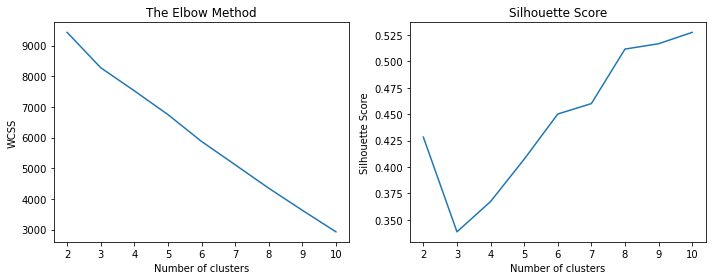

In [71]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

The elbow method doesn't provide a good hint for selecting the best cluster size. The silhouette score is difficult to interpret because the score increases with cluster size, but it's obvious that the too much clustering doesn't make sense for our problem. So we choose 2 as cluster size which would conform with our classification problem and the clustering in 'Survived' and 'Not survived'.

#### 4.8.2 Training the K-Means model on the train dataset

In [72]:
kmeans_train = KMeans(n_clusters=2, init='k-means++', random_state=42)
y_train_kmeans = kmeans_train.fit_predict(X_train)
print(y_train_kmeans)

[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0
 0 0 0 1 0 0 0 1 0 0 0 0 

#### 4.8.3 Adding the cluster number as new feature on the train dataset

In [73]:
y_train_kmeans = y_train_kmeans[:, np.newaxis]
X_train = np.concatenate((X_train, y_train_kmeans), axis=1)

In [74]:
print(np.shape(X_train))
print(X_train)

(712, 19)
[[0.0 0.0 1.0 ... -0.3316790433256366 0.6485339277429727 0]
 [0.0 1.0 0.0 ... -0.4264054204191258 -0.5539560632804559 0]
 [0.0 1.0 0.0 ... 0.10261957931985559 0.6485339277429727 0]
 ...
 [0.0 0.0 1.0 ... -0.4816288743161625 -0.5539560632804559 0]
 [0.0 0.0 1.0 ... -0.2886811164145163 0.04728893223125841 0]
 [0.0 1.0 0.0 ... 0.1424558352520875 0.6485339277429727 0]]


#### 4.8.4 Predict and add the cluster number as new feature on the test dataset

In [75]:
y_test_kmeans = kmeans_train.predict(X_test)
y_test_kmeans = y_test_kmeans[:, np.newaxis]
X_test = np.concatenate((X_test, y_test_kmeans), axis=1)

#### 4.8.5 Predict and add the cluster number as new feature on the prediction dataset

In [76]:
y_pred_kmeans = kmeans_train.predict(X_pred)
y_pred_kmeans = y_pred_kmeans[:, np.newaxis]
X_pred = np.concatenate((X_pred, y_pred_kmeans), axis=1)

### 4.9 Build the XGBoost model

In [77]:
classifier = XGBClassifier(n_estimators=1000, learning_rate=0.05, subsample=0.3, reg_alpha=3)
classifier.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.67350
[1]	validation_0-logloss:0.65546
[2]	validation_0-logloss:0.63808
[3]	validation_0-logloss:0.62524
[4]	validation_0-logloss:0.61005
[5]	validation_0-logloss:0.59849
[6]	validation_0-logloss:0.58392
[7]	validation_0-logloss:0.57217
[8]	validation_0-logloss:0.56203
[9]	validation_0-logloss:0.55310
[10]	validation_0-logloss:0.54494
[11]	validation_0-logloss:0.53558
[12]	validation_0-logloss:0.52957
[13]	validation_0-logloss:0.52276
[14]	validation_0-logloss:0.51559
[15]	validation_0-logloss:0.51034
[16]	validation_0-logloss:0.50326
[17]	validation_0-logloss:0.49714
[18]	validation_0-logloss:0.49077
[19]	validation_0-logloss:0.48547
[20]	validation_0-logloss:0.47888
[21]	validation_0-logloss:0.47366
[22]	validation_0-logloss:0.46919
[23]	validation_0-logloss:0.46649
[24]	validation_0-logloss:0.46291
[25]	validation_0-logloss:0.46039
[26]	validation_0-logloss:0.45790
[27]	validation_0-logloss:0.45349
[28]	validation_0-logloss:0.45027
[29]	validation_0-loglos

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-logloss:0.42716
[38]	validation_0-logloss:0.42580
[39]	validation_0-logloss:0.42345
[40]	validation_0-logloss:0.42194
[41]	validation_0-logloss:0.42156
[42]	validation_0-logloss:0.42071
[43]	validation_0-logloss:0.41837
[44]	validation_0-logloss:0.41796
[45]	validation_0-logloss:0.41581
[46]	validation_0-logloss:0.41560
[47]	validation_0-logloss:0.41318
[48]	validation_0-logloss:0.41364
[49]	validation_0-logloss:0.41325
[50]	validation_0-logloss:0.41316
[51]	validation_0-logloss:0.41221
[52]	validation_0-logloss:0.41147
[53]	validation_0-logloss:0.40975
[54]	validation_0-logloss:0.40865
[55]	validation_0-logloss:0.40604
[56]	validation_0-logloss:0.40550
[57]	validation_0-logloss:0.40520
[58]	validation_0-logloss:0.40426
[59]	validation_0-logloss:0.40433
[60]	validation_0-logloss:0.40400
[61]	validation_0-logloss:0.40239
[62]	validation_0-logloss:0.40084
[63]	validation_0-logloss:0.40039
[64]	validation_0-logloss:0.39942
[65]	validation_0-logloss:0.39839
[66]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### 4.10. Predict Test set (model development )

In [78]:
y_model_pred = classifier.predict(X_test)

In [79]:
print(np.concatenate((y_model_pred.reshape(len(y_model_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 1]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 1]
 [1 0]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]

### 4.11. Print Confusion Matrix

In [80]:
print(confusion_matrix(y_test, y_model_pred))

[[98 12]
 [20 49]]


In [81]:
print(accuracy_score(y_test, y_model_pred) * 100)

82.12290502793296


### 4.12. Applying k-Fold Cross Validation

In [82]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 83.86 %
Standard Deviation: 2.40 %


### 4.13. Predict Test set (with unknown results)

In [83]:
y_pred = classifier.predict(X_pred)

In [84]:
print(y_pred)

[0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


### 4.14. Create result dataframe and print it to csv

In [85]:
print(len(y_pred))

418


In [86]:
result = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_pred})
print(result)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


In [87]:
result.to_csv('../00_data/xgboost_12.csv', index=False)